In [ ]:
!pip install deap
from deap import base
from deap import creator
from deap import tools

import numpy as np
import random
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

# Выбор параметров для алгоритма:

* размер популяции
* количество генов
* вероятность кроссовера
* вероятность мутации
* количестов поколений

Есть возможность применить раннюю остановку алгоритма, задав USE_DELTA = True. Остановка происходит при условии, что каждый последующий лучший и средний результат (можно обнулить его влияние, задав бОльшее значение) меньше дельты на протяжении N_DELTA_GENERATIONS поколений.

In [ ]:
# Genetic Algorithm constants:
POPULATION_SIZE = 50
N_GENS = 10 
P_CROSSOVER = 0.5 
P_MUTATION = 0.1   
MAX_GENERATIONS = 40 

# Early stopping
USE_DELTA = True
MAX_DELTA = 0.01  # max result delta 
MEAN_DELTA = 0.01  # mean result delta 
N_DELTA_GENERATIONS = 5  # number of generations < MAX_DELTA to stop

# Определение используемых функций:

Создане класса популяции происходит в функции populationCreator. Она создаёт индивидуумов через функцию individualCreator. Класс индивидуума Individual состоит из веса, заданного FitnessMax, и вектором, заполненным zeroOrOne длиной N_GENS.

Далее необходимо выбрать желаемые функции для основных операций алгоритма:

* отбор select 
* скрещивание mate 
* мутация

In [ ]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# fitness calculation:

# convert to number between [0, 7]
def individual_to_number(individual):
  int_individual = int("".join(str(x) for x in individual), 2)
  return int_individual*7/(2**N_GENS - 1)

# get function result
def function(individual):
  return (individual + 1.3) * np.sin(0.5 * np.pi * individual  + 1)

# compute the fitness function
def functionFitness(individual):
  real_individual = individual_to_number(individual)
  return function(real_individual) ,  # return a tuple


toolbox.register("evaluate", functionFitness)
SELECTION = 'Tournament'
toolbox_selection = {'Roulette':{'function':tools.selRoulette}, 
                     'Tournament': {'function':tools.selTournament, 'tournsize':3}, 
                     'StochasticUniversalSampling':{'function':tools.selStochasticUniversalSampling}}
MATE = 'OnePoint'
toolbox_mate = {'OnePoint':{'function':tools.cxOnePoint}, 
                'Uniform':{'function':tools.cxUniform, 'indpb':0.1}}

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


# Цикл алгоритма:

1. создание популяции
2. вычисление значений функции
3. обнуление всех хранимых значений
4. начало цикла, пока не стоит флаг ранней остановки и не превышено количество поколений
5. селекция
6. скрещивание 
7. мутация
8. вычисление значений функции
9. сохранение данных, выбор лучших значений
10. проверка на раннюю остановку, если она используется

 

In [ ]:
# Genetic Algorithm flow:

def genetic_algorithm(POPULATION=None,
                      POPULATION_SIZE=POPULATION_SIZE,
                      P_CROSSOVER=P_CROSSOVER,
                      P_MUTATION=P_MUTATION,
                      MAX_GENERATIONS=MAX_GENERATIONS,
                      SELECTION=SELECTION,
                      MATE=MATE):
  # create the individual operator to fill up an Individual instance:
  toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, N_GENS)
  # create the population operator to generate a list of individuals:
  toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

  # genetic operators:

  # Using selection function:
  toolbox.register("select", **toolbox_selection[SELECTION])

  # Using crossover:
  toolbox.register("mate", **toolbox_mate[MATE])

  # Flip-bit mutation:
  # indpb: Independent probability for each attribute to be flipped
  toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/N_GENS)


  # create initial population (generation 0):
  if POPULATION == None:
    population = toolbox.populationCreator(n=POPULATION_SIZE)
  else:
    population = POPULATION.copy()
  generationCounter = 0

  # calculate fitness tuple for each individual in the population:
  fitnessValues = list(map(toolbox.evaluate, population))
  for individual, fitnessValue in zip(population, fitnessValues):
      individual.fitness.values = fitnessValue

  # extract fitness values from all individuals in population:
  fitnessValues = [individual.fitness.values[0] for individual in population]
  bestFitnessValueEver = max(fitnessValues)
  individuals = list(map(individual_to_number, population))
  bestIndividualEver = individuals[fitnessValues.index(bestFitnessValueEver)]
  bestGeneration = 0

  # initialize statistics accumulators:
  bestIndividuals = []
  maxFitnessValues = []
  meanFitnessValues = []

  all_Individuals = []
  all_FitnessValues = []

  stop_delta_flag = False
  delta_generations=0
  # main evolutionary loop:
  # stop if max fitness value reached the known max value
  # OR if number of generations exceeded the preset value:
  while not stop_delta_flag and generationCounter < MAX_GENERATIONS:
      # update counter:
      generationCounter = generationCounter + 1

      # apply the selection operator, to select the next generation's individuals:
      offspring = toolbox.select(population, POPULATION_SIZE)
      # clone the selected individuals:
      offspring = list(map(toolbox.clone, offspring))
      random.shuffle(offspring)

      # apply the crossover operator to pairs of offspring:
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < P_CROSSOVER:
              toolbox.mate(child1, child2)
              del child1.fitness.values
              del child2.fitness.values

      for mutant in offspring:
          if random.random() < P_MUTATION:
              toolbox.mutate(mutant)
              del mutant.fitness.values

      # calculate fitness for the individuals with no previous calculated fitness value:
      freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
      freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
      for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
          individual.fitness.values = fitnessValue

      # replace the current population with the offspring:
      population[:] = offspring

      # collect fitnessValues into a list, update statistics and print:
      int_individuals = list(map(individual_to_number, population))
      all_Individuals += [int_individuals]
      fitnessValues = [ind.fitness.values[0] for ind in population]
      all_FitnessValues += [fitnessValues]

      maxFitness = max(fitnessValues)
      meanFitness = sum(fitnessValues) / len(population)
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      # print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))

      # find and print best individual:
      best_individual_index = fitnessValues.index(max(fitnessValues))
      best_individual = int_individuals[best_individual_index]
      bestIndividuals.append(best_individual)
      # print("Best Individual = ", int_individuals[best_individual_index])
      # print("Unique individuals = ", len(set(int_individuals)), "\n")

      if maxFitness > bestFitnessValueEver:
        bestIndividualEver = best_individual
        bestFitnessValueEver = maxFitness
        bestGeneration = generationCounter

      if USE_DELTA:
        if generationCounter > N_DELTA_GENERATIONS:
          if abs(maxFitnessValues[-2] - maxFitnessValues[-1]) < MAX_DELTA and \
          abs(meanFitnessValues[-2] - meanFitnessValues[-1]) < MEAN_DELTA:
            delta_generations += 1
          else:
            delta_generations = 0
          if delta_generations == N_DELTA_GENERATIONS:
            stop_delta_flag = True
            print('Early stopping: ', generationCounter)
  return maxFitnessValues, meanFitnessValues, (bestIndividualEver,bestFitnessValueEver,bestGeneration), (bestIndividuals,all_Individuals,all_FitnessValues)

In [ ]:
def print_best(text, stats):
  print(text)
  print("Max Fitness =", stats[0]) 
  print("Best x = ",stats[1])
  print("Generation ", stats[2])
  print()

# Графики зависисмостей

Roulette
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  12

Tournament
Max Fitness = 4.427174975562072
Best x =  5.698443587495144
Generation  1

StochasticUniversalSampling
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  8



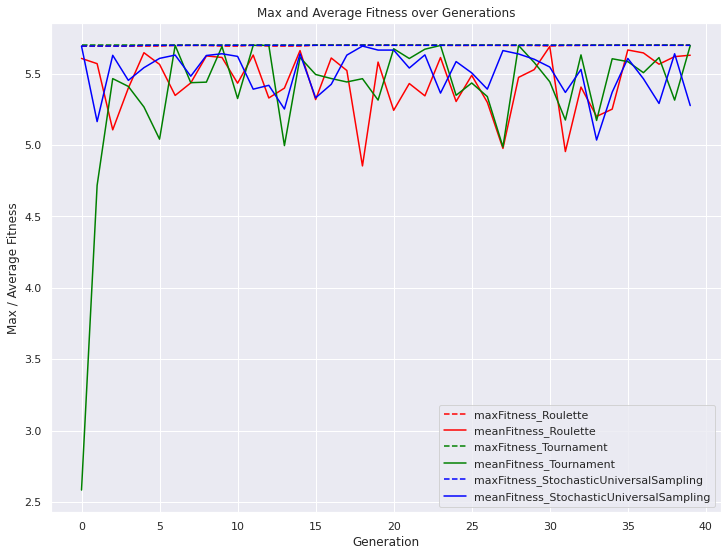

In [ ]:
colors = ['red', 'green', 'blue','black']
names = []
max_values = []
mean_values = []
population = toolbox.populationCreator(n=POPULATION_SIZE)
for key, value in toolbox_selection.items():
  results = genetic_algorithm(POPULATION=population, SELECTION=key)
  max_values.append(results[0])
  mean_values.append(results[1])
  names.append(key)
  print_best(key, results[2])

# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,9)})
for i in range(len(toolbox_selection)):
  plt.plot(max_values[i], color=colors[i],linestyle='dashed', label='maxFitness_'+names[i])
  plt.plot(mean_values[i], color=colors[i], label='meanFitness_'+names[i])
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

OnePoint
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  0

Uniform
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  0



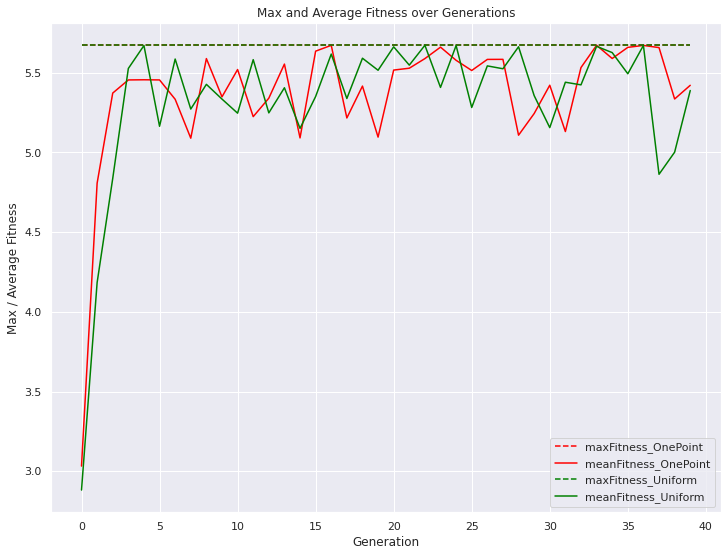

In [ ]:
colors = ['red', 'green', 'blue','black']
names = []
max_values = []
mean_values = []
population = toolbox.populationCreator(n=POPULATION_SIZE)
for key, value in toolbox_mate.items():
  results = genetic_algorithm(POPULATION=population, MATE=key)
  max_values.append(results[0])
  mean_values.append(results[1])
  names.append(key)
  print_best(key, results[2])

# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,9)})
for i in range(len(toolbox_mate)):
  plt.plot(max_values[i], color=colors[i],linestyle='dashed', label='maxFitness_'+names[i])
  plt.plot(mean_values[i], color=colors[i], label='meanFitness_'+names[i])
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

0.1
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  15

0.3
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  9

0.5
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  13

0.7
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  6

0.9
Max Fitness = 4.372434017595308
Best x =  5.671860386452198
Generation  10



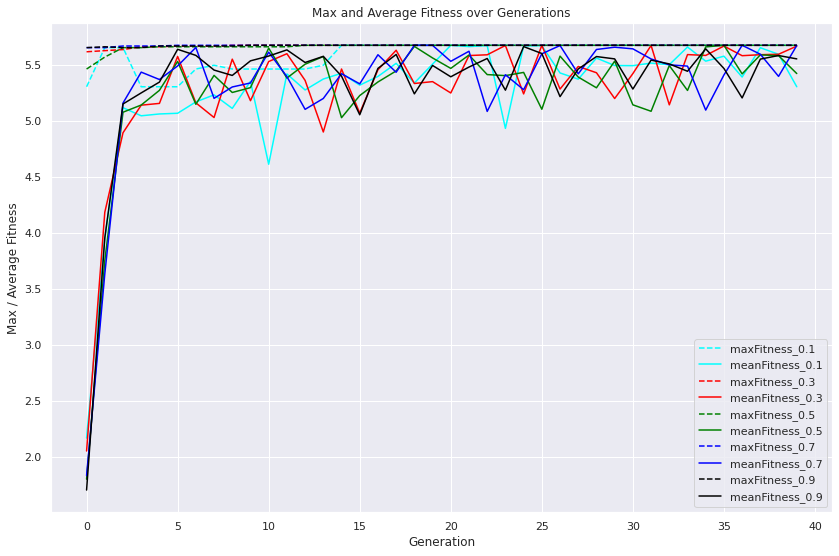

In [ ]:
colors = ['cyan','red', 'green', 'blue','black']
names = []
max_values = []
mean_values = []
population = toolbox.populationCreator(n=30)
for n in [0.1, 0.3, 0.5, 0.7, 0.9]:
  results = genetic_algorithm(POPULATION=population, P_CROSSOVER=n)
  max_values.append(results[0])
  mean_values.append(results[1])
  names.append(str(n))
  print_best(n, results[2])

# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14,9)})
for i in range(len(names)):
  plt.plot(max_values[i], color=colors[i],linestyle='dashed', label='maxFitness_'+names[i])
  plt.plot(mean_values[i], color=colors[i], label='meanFitness_'+names[i])
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

0.01
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  4

0.1
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  12

0.3
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  12

0.5
Max Fitness = 4.427174975562072
Best x =  5.698443587495144
Generation  3

0.7
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  3



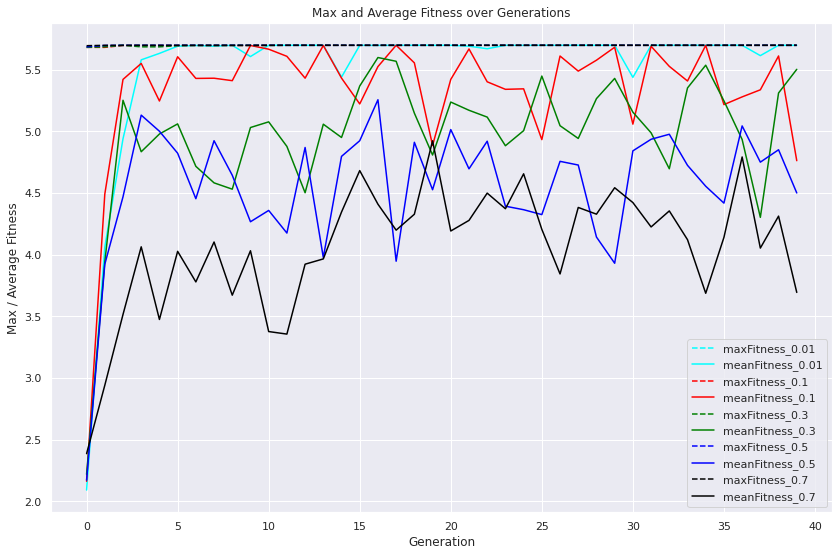

In [ ]:
colors = ['cyan','red', 'green', 'blue','black']
names = []
max_values = []
mean_values = []
population = toolbox.populationCreator(n=POPULATION_SIZE)
for n in [0.01, 0.1, 0.3, 0.5, 0.7]:
  results = genetic_algorithm(POPULATION=population, P_MUTATION=n)
  max_values.append(results[0])
  mean_values.append(results[1])
  names.append(str(n))
  print_best(n, results[2])

# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14,9)})
for i in range(len(names)):
  plt.plot(max_values[i], color=colors[i],linestyle='dashed', label='maxFitness_'+names[i])
  plt.plot(mean_values[i], color=colors[i], label='meanFitness_'+names[i])
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

5
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  13

10
Max Fitness = 4.427174975562072
Best x =  5.698443587495144
Generation  9

40
Max Fitness = 4.427174975562072
Best x =  5.698443587495144
Generation  7

60
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  13

100
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  6



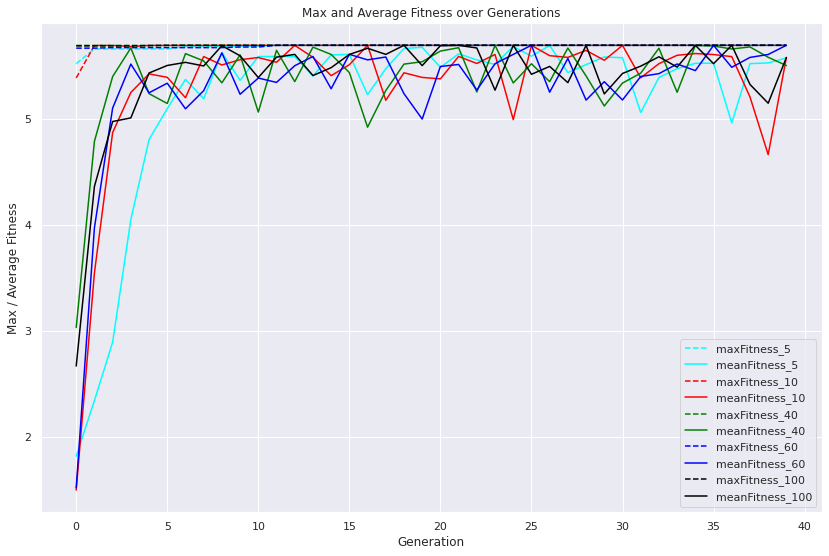

In [ ]:
colors = ['cyan','red', 'green', 'blue','black']
names = []
max_values = []
mean_values = []
for n in [5, 10, 40, 60, 100]:
  population = toolbox.populationCreator(n=n)
  results = genetic_algorithm(POPULATION=population)
  max_values.append(results[0])
  mean_values.append(results[1])
  names.append(str(n))
  print_best(n, results[2])

# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14,9)})
for i in range(len(names)):
  plt.plot(max_values[i], color=colors[i],linestyle='dashed', label='maxFitness_'+names[i])
  plt.plot(mean_values[i], color=colors[i], label='meanFitness_'+names[i])
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

5
Max Fitness = 4.516129032258065
Best x =  5.6495137214788365
Generation  38

10
Max Fitness = 4.4340175953079175
Best x =  5.698756793661487
Generation  0

40
Max Fitness = 4.433103799817611
Best x =  5.698753963928164
Generation  40

60
Max Fitness = 4.399995565475958
Best x =  5.690570363978192
Generation  40

100
Max Fitness = 4.429558964165432
Best x =  5.698629188749203
Generation  38



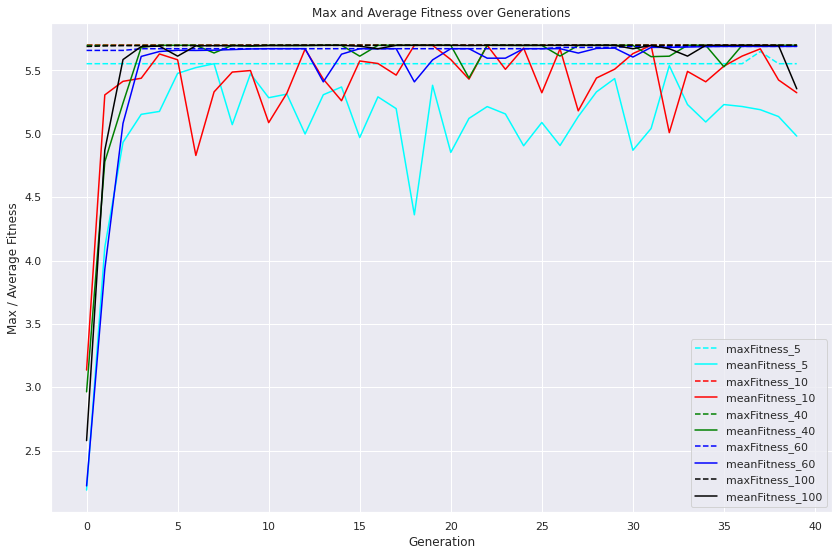

In [ ]:
colors = ['cyan','red', 'green', 'blue','black']
names = []
max_values = []
mean_values = []
for n in [5, 10, 40, 60, 100]:
  N_GENS=n
  results = genetic_algorithm()
  max_values.append(results[0])
  mean_values.append(results[1])
  names.append(str(n))
  print_best(n, results[2])

# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(14,9)})
for i in range(len(names)):
  plt.plot(max_values[i], color=colors[i],linestyle='dashed', label='maxFitness_'+names[i])
  plt.plot(mean_values[i], color=colors[i], label='meanFitness_'+names[i])
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

# График обучения

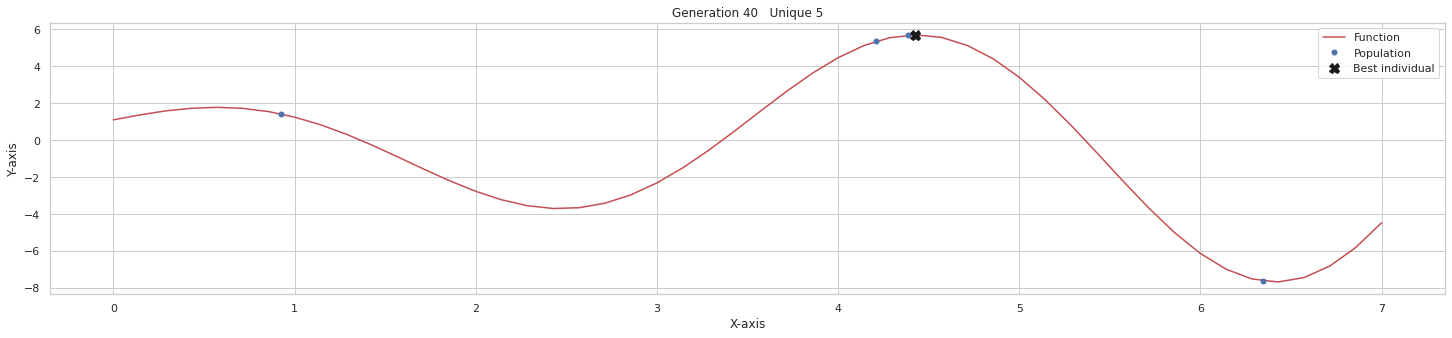

In [ ]:
sns.set_style("whitegrid")

x = np.linspace(0, 7, 50)
y = list(map(function, x))

figure, ax = plt.subplots(figsize=(25, 5))
results = genetic_algorithm() 
# Loop
for i in range(len(results[0])):
    ax.cla()
    ax.plot(x, y, 'r-', label='Function')
    ax.plot(results[3][1][i], results[3][2][i], 'bo', markersize=5,  label='Population')
    ax.plot(results[3][0][i], results[0][i], 'kX', markersize=10, label='Best individual')

    # setting labels
    plt.legend()
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Generation "+str(i+1)+'   Unique '+str(len(set(results[3][2][i]))))

    display(figure)    
    time.sleep(0.8)
    clear_output(wait = True)